In [1]:
# Forward stagewise regression: Boosting for linear regression
linRegFS <- function(X, y, eps=NULL, center = T, scale = T, tol=1e-8, maxIter=1000){
  
  n  <- nrow(X)
  p  <- ncol(X)
  # ns <- length(lambda)
  
  #Check standardization consistency 
  if(!center & scale){
    warning("Centering is required when 'scale' is TRUE. 'center' is automatically set to be TRUE.")
    center <- TRUE
  }
  
  #Centering, Scaling or do nothing
  if(center){
    # beta <- matrix(0,p,ns)
    ym <- mean(y)
    y  <- y-ym
    Xm <- colMeans(X)
    X <- scale(X,center = T,scale = F)
    if(scale){
      Xsd <- sqrt(colMeans(X^2))
      X <- apply(X,MARGIN = 1,function(X,sd) X/sd,sd=Xsd)
      X <- t(X)
    }
  }

  beta <- matrix(0,p,maxIter)    # solution path for beta
  beta0 <- rep(0,maxIter)        # solution path for beta0/intercept
  betat <- rep(0,p)         # initialize beta by zero
  yhat <- rep(0,n)
  
  for(iter in 1:maxIter){
    r <- y - yhat
    g <- t(X)%*%r
    
    if(is.null(eps)) eps <- max(abs(g))/sum(r^2)
    idx <- which.max(abs(g))
    betat[idx] <- betat[idx] + eps*sign(g[idx])
    yhat <- yhat + eps*sign(g[idx])*X[,idx]
    beta[,iter] <- betat
    
    corr <- max(abs(g))/n/sd(r)
    cat(iter,"-th iteration;\t updating",idx,"-th coefficient;\t eps:",eps,";\t max corr:",corr,"\n")
    if(corr<tol){
      beta <- beta[,1:iter]
      break
    }
  }
  
  #Recover the intercept
  if(scale){
    beta0 <- ym - t(Xm/Xsd)%*%beta
    beta <- beta/Xsd
  } else if(center){
    beta0 <- ym - Xm%*%beta
  } else{
    beta0 <- ym
  }
  
  beta <- list(beta=beta,beta0=beta0,eps=eps,iteration=iter)
  attr(beta, "class") <- "linRegFS"
  return(beta)
}


In [2]:
library(glmnet)
rm(list=ls())
source("/Users/cmx/Desktop/PRML practice/Lasso/Lasso.R")
source("/Users/cmx/Desktop/PRML practice/linRegFS.R")
set.seed(100)
ntrain <- 100
p <- 1000
c0 <- 2
xtrain <- 2*matrix(rnorm(ntrain*p),ntrain,p) + c0
xtrain[,1] <- xtrain[,1] * 3

b <- rep(0,p)
b[1:10] <- rnorm(10)

b0 <- 1
ytrain <- xtrain%*%b + b0 + rnorm(ntrain,0,sqrt(0.5*var(xtrain%*%b)))#rnorm(ntrain,0,1)

# centerize xtrain
cc <- colMeans(xtrain)
xtrain2 <- t(t(xtrain) - cc)

# standardize xtrain?
standardizeX <- T

if(standardizeX){
  s <- sqrt(colMeans(xtrain2^2))
  xtrain2 <- t(t(xtrain2)/s)
}

# get lambda sequence
MaxLam <- max(abs(t(xtrain2)%*%ytrain))
loglam <- seq(log10(MaxLam),log10(0.2*MaxLam),length.out = 100)
lam <- 10^(loglam)

# fit using glmnet
# fitglmnet <- glmnet(xtrain,ytrain,alpha=1,lambda = lam/ntrain,standardize = T,thresh = 1e-10)
fitLasso1 <- Lasso(xtrain,ytrain,center = T,scale = T,lambda = lam,method="ACD")
fitFS <- linRegFS(xtrain,ytrain,center = T,scale = T, maxIter = 350)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



 Finished!	 1  outer loops;	 0  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  inner loops
 Finished!	 2  outer loops;	 1  

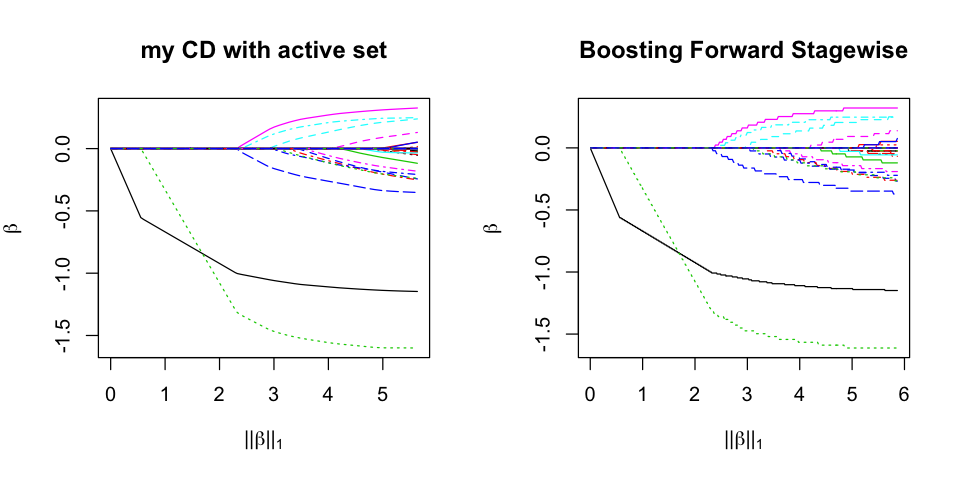

In [3]:
library(repr)
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
matplot(colSums(abs(fitLasso1$beta)),t(fitLasso1$beta),type="l",xlab=expression("||"*beta*"||"[1]),ylab=expression(beta),main="my CD with active set")
matplot(colSums(abs(fitFS$beta)),t(fitFS$beta),type="l",xlab=expression("||"*beta*"||"[1]),ylab=expression(beta),main="Boosting Forward Stagewise")